本次程式碼範例的目標是藉由程式碼直觀地去理解：一張圖片經過 YOLO 網路之後，這個 7 x 7 x 30 的 tensor 裡面的值應該會是什麼樣子？

In [8]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("image/dog.jpg")
h, w, _ = img.shape

你可以觀察到圖片裡面有狗、腳踏車和一輛車

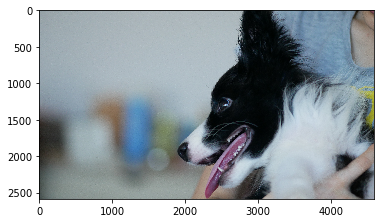

In [9]:
def show(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # plt.imshow 預設圖片是 rgb 的
    plt.show()

show(img)

假設我們知道這張中汽車、狗和腳踏車的 bounding boxes 訊息

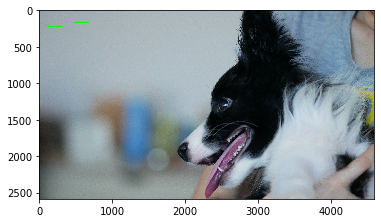

In [10]:
boxes = np.array([[128, 224, 314, 537], [475, 85, 689, 170], [162, 119, 565, 441]]).astype(float)
# 把 bounding boxes 坐標以原圖的 Resolution normalize 至 0 ~ 1 之間
boxes[:, [0, 2]] = boxes[:, [0, 2]] / img.shape[1]
boxes[:, [1, 3]] = boxes[:, [1, 3]] / img.shape[0]

img_show = img.copy()
for x1, y1, x2, y2 in boxes:
    cv2.rectangle(img_show, (int(x1 * w), int(y1 * h)), (int(x2 * w), int(y2 * h)), (0, 255, 0), 2)

show(img_show)

VOC 這是一個標註有 20 類物體的資料集，詳細介紹可以參考[PASCAL VOC 簡介](https://arleyzhang.github.io/articles/1dc20586/)

而汽車、狗和腳踏車所對應的 class index 分別是 1, 7, 16

In [11]:
labels = np.array([1, 7, 16]) 

有了 bounding boxes 以及類別的信息，接下來我們就來建構這張圖片在經過 YOLO 網路後應該要輸出的 tensor

In [12]:
grid_num = 7 # 把圖片切成 7 x 7 的網格
target = np.zeros((grid_num, grid_num, 30)) # 初始化 YOLO 目標預測值, 30 代表什麼, 請參考簡報
print("YOLO 網路輸出 tensor 的 shape: ", target.shape)

YOLO 網路輸出 tensor 的 shape:  (7, 7, 30)


In [14]:
# 一個網格的大小
cell_size = 1 / grid_num

# bounding boxes 的 width 以及 height
w_h = boxes[:, 2:] - boxes[:, :2]

# bounding boxes 的中心
cx_cy = (boxes[:, 2:] + boxes[:, :2]) / 2

for i in range(len(boxes)):
    cx_cy_sample = cx_cy[i]

    # bounding boxes 中心所坐落的網路 index
    i_j = np.ceil((cx_cy_sample / cell_size)) - 1

    # 該網格第一個 box 的 confidence 信息
    target[int(i_j[1]), int(i_j[0]), 4] = 1

    # 該網格第二個 box 的 confidence 信息 
    target[int(i_j[1]), int(i_j[0]), 9] = 1
    
    # 該網格的類別信息
    target[int(i_j[1]),int(i_j[0]),int(labels[i]) + 9] = 1
    
    # 匹配到的網格的左上角相對坐標
    x_y = i_j * cell_size
    
    # 該網格的 x, y, w, h
    delta_x_y = (cx_cy_sample - x_y) / cell_size
    target[int(i_j[1]), int(i_j[0]), 2:4] = w_h[i]
    target[int(i_j[1]), int(i_j[0]), :2] = delta_x_y
    target[int(i_j[1]), int(i_j[0]), 7:9] = w_h[i]
    target[int(i_j[1]), int(i_j[0]), 5:7] = delta_x_y

print("顯示 7x7x30 中，第一個 box 的 confidence 信息\n", target[:, :, 4])

顯示 7x7x30 中，第一個 box 的 confidence 信息
 [[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


上面的 tensor 中, 為 1 的表示那個網格是有物體的, 為 0 就表示沒有物體

我們可以把帶有 7x7 網格的圖畫出來比對一下

看看汽車、狗和腳踏車的中心是不是恰好就是這個 tensor 中值為 1 的網格呢

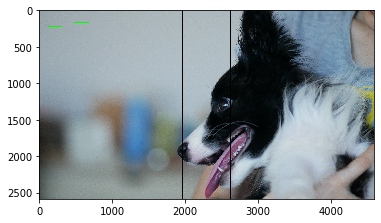

In [15]:
for h in np.arange(0, img.shape[0], img.shape[0] / grid_num).astype(int):
    cv2.line(img_show, (0, h), (img.shape[1], h), (0, 0, 0), 2)

for w in np.arange(0, img.shape[1], img.shape[1] / grid_num).astype(int):
    cv2.line(img_show, (w, 0), (w, img.shape[0]), (0, 0, 0), 2)

show(img_show)

請問在 YOLOv1 的設計下，一張圖片最多能檢測出多少個 bbox 呢？
49 個